In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS
import matplotlib.dates as mdates
from tqdm import tqdm 

In [29]:
fires = gpd.read_file("../Data/Output/fires_2020_2022_LA.shp")
pa    = gpd.read_file("../Data/Output/PurpleAir_after_Calibration.shp")

fires["ALARM_DATE"] = pd.to_datetime(fires["ALARM_DATE"])
pa["date"]          = pd.to_datetime(pa["date"]) 

In [35]:
pa.columns = ['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
               'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
               'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
               'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
               'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
               'longitude', 'altitude', 'confidence', 'pm25_avg', 'PA_PM25',
               'PA_RH', 'PA_T', 'PA_PM25cali_025', 'PA_PM25cali_05', 'diff_05',
               'diff_025', 'geometry']

In [186]:
PM_COL = "PA_PM25cali_05"
proj   = CRS.from_epsg(3310)

fires_p = fires.to_crs(proj)
pa_p    = pa.to_crs(proj)

RADII = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
MILE  = 1609.344

records = []
for idx, fire in tqdm(fires_p.iterrows(), total = len(fires_p), desc="Fires"):
    fid   = fire["OBJECTID"]
    fname = fire.get("FIRE_NAME", "")
    adate = fires.loc[idx, "ALARM_DATE"]

    start = adate - pd.Timedelta(days = 30)
    end   = adate + pd.Timedelta(days = 30)
    days  = pd.date_range(start, end, freq = "D")

    for r in RADII:
        geom_buf = fire.geometry.buffer(r * MILE)

        # 先一次性挑出缓冲区内的传感器观测
        pa_sub = pa_p[pa_p.within(geom_buf)].copy()
        if pa_sub.empty:
            pa_sub = pa_p.iloc[0:0].copy()

        # 按天聚合：列出 sensor_id 列表 + 其他统计
        grp = (pa_sub.groupby("date")
                      .agg(sensor_ids = ("sensor_id", lambda s: list(s.unique())),
                           PA_count   = ("sensor_id", "nunique"),
                           PA_mean    = (PM_COL, "mean"))
              )

        grp = grp.reindex(days)
        grp["sensor_ids"] = grp["sensor_ids"].apply(
            lambda x: x if isinstance(x, list) else [])
        grp["PA_count"] = grp["PA_count"].fillna(0).astype(int)

        grp = grp.reset_index().rename(columns={"index": "date"})
        grp["DAY"]        = (grp["date"] - adate).dt.days # (-30, 30)
        grp["buffer_mi"]  = r
        grp["FIRE_NAME"]  = fname
        grp["OBJECTID"]   = fid

        records.append(grp)

wf_buffer_daily = pd.concat(records, ignore_index=True)
print(wf_buffer_daily.head())

Fires: 100%|██████████| 55/55 [03:33<00:00,  3.88s/it]

        date sensor_ids  PA_count  PA_mean  DAY  buffer_mi FIRE_NAME  OBJECTID
0 2021-10-12         []         0      NaN  -30          1    MIDDLE       769
1 2021-10-13         []         0      NaN  -29          1    MIDDLE       769
2 2021-10-14         []         0      NaN  -28          1    MIDDLE       769
3 2021-10-15         []         0      NaN  -27          1    MIDDLE       769
4 2021-10-16         []         0      NaN  -26          1    MIDDLE       769


In [194]:
# 不同buffer里的sensor存在重叠的情况
# wf_buffer_daily_clean = wf_buffer_daily[wf_buffer_daily["sensor_ids"].str.len() >= 20].copy()
# wf_buffer_daily_clean.head()

,date,sensor_ids,PA_count,PA_mean,DAY,buffer_mi,FIRE_NAME,OBJECTID
1158,2021-01-12,"[12066, 17529, 17579, 17583, 1852, 28547, 2889...",21,7.514602,30,7,CANYON,1416
1182,2020-12-06,"[12066, 1656, 17529, 17579, 17583, 1852, 28547...",20,19.452142,-7,8,CANYON,1416
1186,2020-12-10,"[12066, 1656, 17529, 17579, 17583, 1852, 28547...",20,16.178367,-3,8,CANYON,1416
1187,2020-12-11,"[12066, 1656, 17529, 17579, 17583, 1852, 28547...",20,13.134519,-2,8,CANYON,1416
1188,2020-12-12,"[12066, 1656, 17529, 17579, 17583, 1852, 28547...",20,17.302020,-1,8,CANYON,1416


In [258]:
def check_sensors_in_different_distance_range(group):
    group = group.sort_values("buffer_mi").copy()
    seen  = set()

    for idx, row in group.iterrows():
        ids = set(row.sensor_ids)
        new_ids = ids - seen
        seen |= ids
        group.at[idx, "sensor_ids"] = list(new_ids)
        group.at[idx, "PA_count"] = len(new_ids)
    return group


wf_buffer_daily_annulus = (
    wf_buffer_daily
      .groupby(["OBJECTID", "date"], group_keys = False) 
      .apply(check_sensors_in_different_distance_range)
)


wf_buffer_daily_clean = wf_buffer_daily_annulus[
    wf_buffer_daily_annulus["PA_count"] >= 15
].copy()

# ---------------------------------------------------------------
# wf_buffer_daily_clean 现在满足：
#   • buffer=1 → 0‒1 mile
#   • buffer=2 → 1‒2 mile
#   • buffer=3 → 2‒3 mile
#   ···········································
# 同一 (OBJECTID, date) 组合里，不会再有重复的 sensor_id
# 后续绘图/分析直接用 wf_buffer_daily_clean 即可

In [264]:
wf_buffer_daily_clean['buffer_mi'].value_counts()

buffer_mi
20    2074
15    1458
10     360
9      237
8      149
7      119
6      115
5      113
4        2
Name: count, dtype: int64

In [266]:
wf20 = wf_buffer_daily_clean.copy()
# 把sensor_ids列的列表打开为多列
tmp = (
    wf20[["OBJECTID", "buffer_mi", "DAY", "date", "sensor_ids"]]
    .explode("sensor_ids", ignore_index = True)
    .rename(columns = {"sensor_ids": "sensor_id"})
)
tmp.head()

,OBJECTID,buffer_mi,DAY,date,sensor_id
0,1416,15,-12,2020-12-01,78849
1,1416,15,-12,2020-12-01,3586
2,1416,15,-12,2020-12-01,29957
3,1416,15,-12,2020-12-01,90119
4,1416,15,-12,2020-12-01,29191


In [268]:
tmp.groupby(['OBJECTID','buffer_mi',"date"]).agg(sensor_count = ('sensor_id','count'))

sensor_count
OBJECTID buffer_mi date                    
489      20        2022-05-16            17
                   2022-05-17            16
                   2022-05-18            18
                   2022-05-19            18
                   2022-05-20            18
...                                     ...
1416     20        2021-01-08           144
                   2021-01-09           141
                   2021-01-10           145
                   2021-01-11           142
                   2021-01-12           142

[4627 rows x 1 columns]

In [270]:
# 根据sensor_id和date在pa表里找到PM2.5数值
merged = tmp.merge(
    pa[["date", "sensor_id", "PA_PM25cali_025"]],
    on = ["date", "sensor_id"],
    how = "left"
)
merged

,OBJECTID,buffer_mi,DAY,date,sensor_id,PA_PM25cali_025
0,1416,15,-12,2020-12-01,78849,10.288358
1,1416,15,-12,2020-12-01,3586,11.542955
2,1416,15,-12,2020-12-01,29957,6.850275
3,1416,15,-12,2020-12-01,90119,137.012878
4,1416,15,-12,2020-12-01,29191,6.553184
...,...,...,...,...,...,...
281709,489,20,28,2022-07-13,55923,14.324944
281710,489,20,28,2022-07-13,15029,7.528218
281711,489,20,28,2022-07-13,56119,14.307019
281712,489,20,28,2022-07-13,56153,13.747124


In [272]:
WF_ValidationTable = (
    merged.groupby(["OBJECTID", "buffer_mi", "DAY"], as_index=False)
          .agg(pm_value_list = ("PA_PM25cali_025",
                              lambda x: x.dropna().tolist()))
)
WF_ValidationTable

,OBJECTID,buffer_mi,DAY,pm_value_list
0,489,20,-30,"[8.29589405107964, 12.213942557467263, 7.71156..."
1,489,20,-29,"[12.194325342933551, 9.228322092037205, 9.0620..."
2,489,20,-28,"[12.804437619465968, 7.202571346993182, 11.025..."
3,489,20,-27,"[17.290595172883382, 7.463681670661738, 14.064..."
4,489,20,-26,"[13.032057667971827, 10.896588942331096, 10.49..."
...,...,...,...,...
4622,1416,20,26,"[8.998720438131073, 22.701692695803136, 6.4348..."
4623,1416,20,27,"[10.369156092371922, 23.38044983313422, 7.1091..."
4624,1416,20,28,"[7.989132640446832, 13.339574592651447, 6.4978..."
4625,1416,20,29,"[7.256569694877641, 13.375466043986874, 17.218..."


# Sensors monitoring wildfire - 5 mi buffer

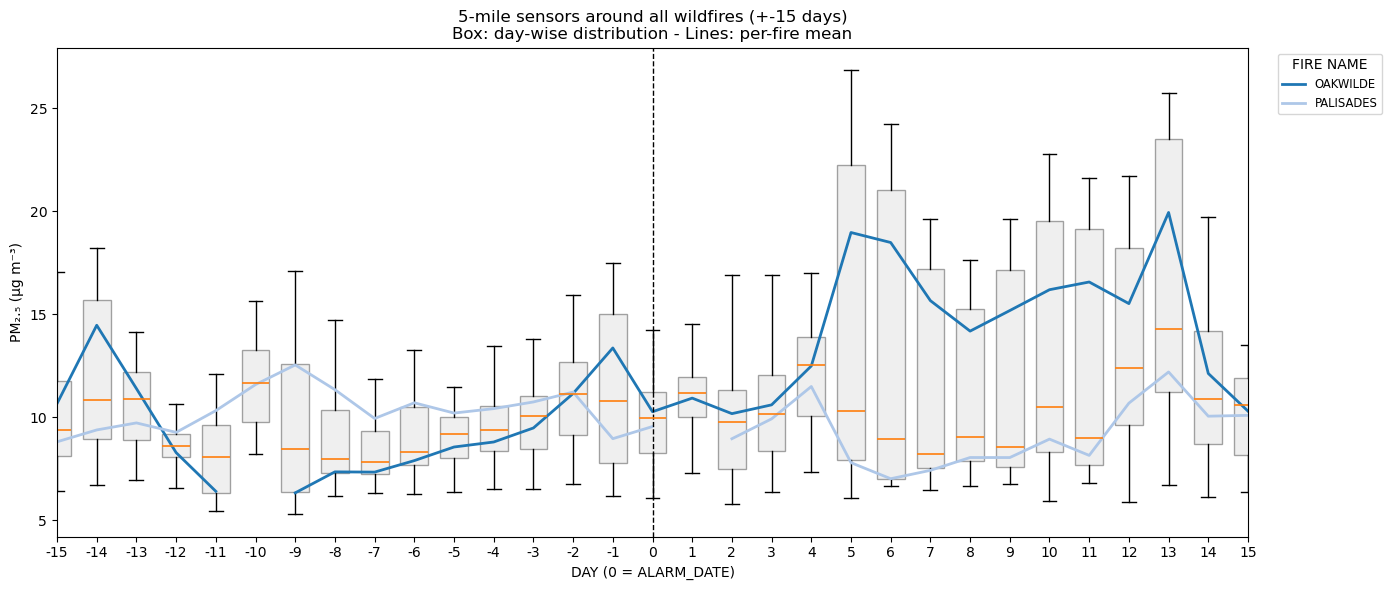

In [313]:
df = WF_ValidationTable.query("buffer_mi == 5 and DAY >= -15 and DAY <= 15").copy()
df = df.merge(fires[["OBJECTID", "FIRE_NAME"]], on = "OBJECTID", how = "left")

offsets = np.arange(-15, 16)
box_data = []
for d in offsets:
    vals = df.loc[df["DAY"] == d, "pm_value_list"].values
    if len(vals):
        box_data.append(np.concatenate(vals))
    else:
        box_data.append(np.array([]))

colors    = plt.cm.tab20.colors
fire_ids  = df["OBJECTID"].unique()

df_exp = (df.explode("pm_value_list")
            .astype({"pm_value_list": "float"}))

mean_df = (df_exp.groupby(["OBJECTID", "DAY"])["pm_value_list"]
                 .mean()
                 .unstack(0)) 

fig, ax = plt.subplots(figsize=(14, 6))

ax.boxplot(box_data,
           positions = offsets,
           widths = 0.7,
           showfliers = False,
           patch_artist = True,
           boxprops = dict(facecolor = "lightgray", alpha=0.35),
           medianprops = dict(linewidth = 1.2))

for i, fid in enumerate(fire_ids):
    y = mean_df[fid]
    ax.plot(offsets, y,
            label = fires.loc[fires['OBJECTID'] == fid, 'FIRE_NAME'].iat[0],
            color = colors[i % len(colors)],
            lw = 2)

ax.set_xlim(-15, 15)
ax.set_xlabel("DAY (0 = ALARM_DATE)")
ax.set_ylabel("PM₂․₅ (µg m⁻³)")
ax.set_title("5-mile sensors around all wildfires (+-15 days)\n"
             "Box: day-wise distribution - Lines: per-fire mean")
ax.axvline(0, color = "k", ls = "--", lw = 1)

if len(fire_ids):
    ax.legend(title = "FIRE NAME", bbox_to_anchor = (1.02, 1),
              loc = "upper left", fontsize = "small")

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


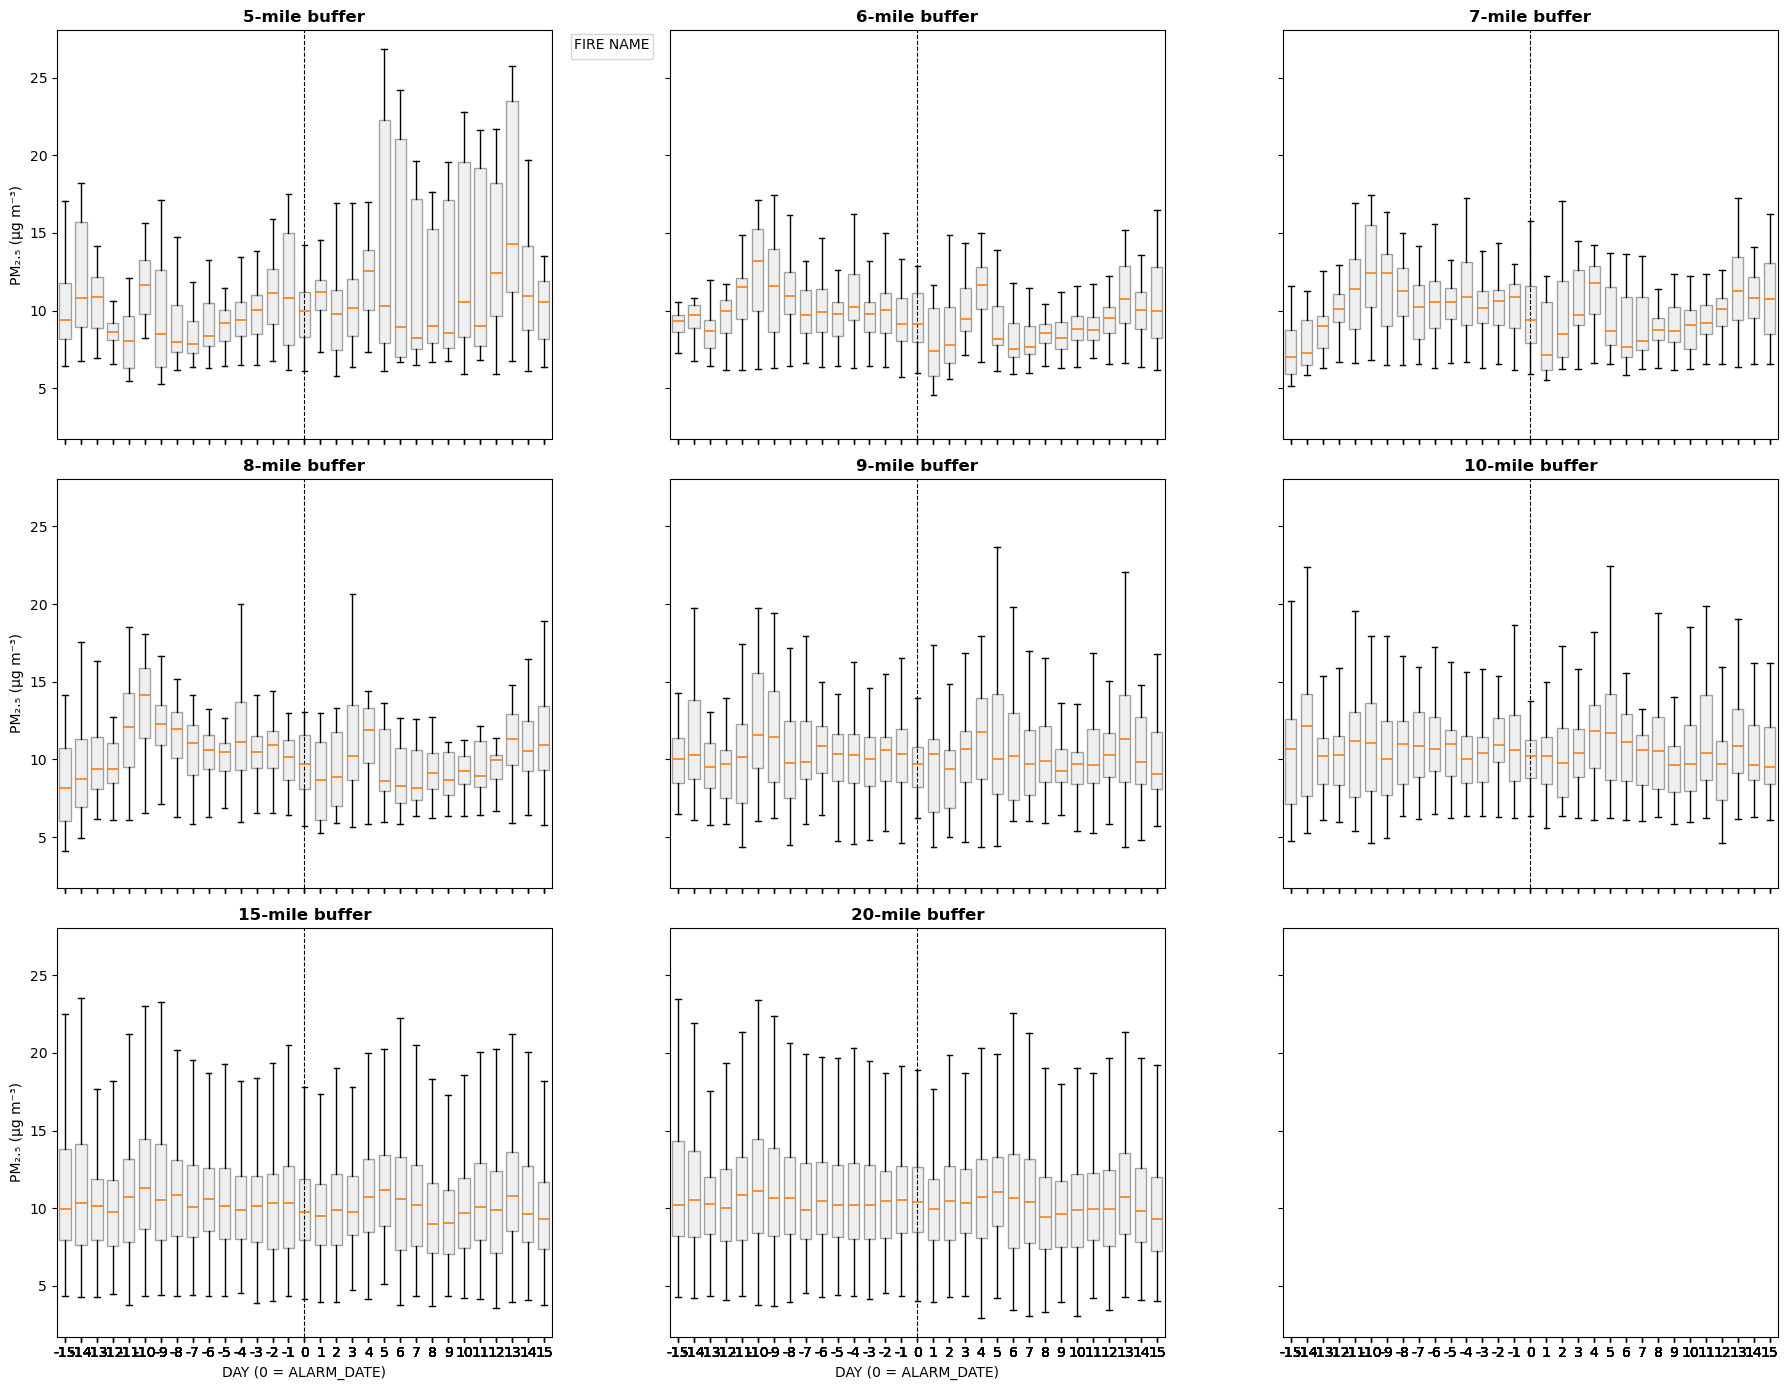

In [276]:
buffer_list = [5, 6, 7, 8, 9, 10, 15, 20]
offsets = np.arange(-15, 16)

fig, axes = plt.subplots(3, 3, figsize=(18, 14), sharex=True, sharey=True)
axes = axes.ravel()

for idx, buf in enumerate(buffer_list):
    ax  = axes[idx]

    sub = (WF_ValidationTable
             .query("buffer_mi == @buf and DAY >= -15 and DAY <= 15")
             .copy()
             .merge(fires[["OBJECTID", "FIRE_NAME"]],
                    on="OBJECTID", how="left"))
    # box chart preparation
    box_data = []
    for d in offsets:
        vals = sub.loc[sub["DAY"] == d, "pm_value_list"].values
        box_data.append(np.concatenate(vals) if len(vals) else np.array([]))

    # line chart prepartion
    sub_exp = (sub.explode("pm_value_list")
                 .astype({"pm_value_list": "float"}))
    mean_df = (sub_exp
                 .groupby(["OBJECTID", "DAY"])["pm_value_list"]
                 .mean()
                 .unstack(0))
    fire_ids = sub["OBJECTID"].unique()
    colors   = plt.cm.tab20.colors

    # box chart
    ax.boxplot(box_data,
               positions   = offsets,
               widths      = 0.7,
               showfliers  = False,
               patch_artist=True,
               boxprops    = dict(facecolor="lightgray", alpha=0.35),
               medianprops = dict(linewidth=1.2))

    # # D-2. 折线（每条 = 一个火场）
    # for i, fid in enumerate(fire_ids):
    #     y = mean_df[fid]                  # 含 NaN
    #     ax.plot(offsets, y,
    #             color = colors[i % len(colors)],
    #             lw    = 1)

    # E. 轴 & 样式
    ax.axvline(0, color="k", ls="--", lw=0.8)
    ax.set_title(f"{buf}-mile buffer", fontweight="bold")

    if idx // 3 == 2:        # 最后一行
        ax.set_xlabel("DAY (0 = ALARM_DATE)")
    if idx % 3 == 0:         # 第一列
        ax.set_ylabel("PM₂․₅ (µg m⁻³)")

# 只给第一幅图加图例，防止重复
if len(fire_ids):
    axes[0].legend(title="FIRE NAME", bbox_to_anchor=(1.03, 1),
                   loc="upper left", fontsize="xx-small")

plt.tight_layout()
plt.show()

# statistical test

In [281]:
from scipy.stats import mannwhitneyu #Mann-Whitney U
from scipy.stats import ttest_ind, wilcoxon
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
import seaborn as sns               # 仅用于可视化，可删

In [399]:
WF_ValidationTable_stas = WF_ValidationTable[~WF_ValidationTable["buffer_mi"].isin([4])].copy()

In [433]:
df_exp = WF_ValidationTable_stas.explode("pm_value_list").astype({"pm_value_list": "float"})
def before_after_stats(d, buf, pre=(-10,-1), post=(1, 5)):
    pre_vals  = d[(d.buffer_mi == buf) & d.DAY.between(*pre)]["pm_value_list"]
    post_vals = d[(d.buffer_mi == buf) & d.DAY.between(*post)]["pm_value_list"]
    # 选用非参数 Mann-Whitney；若数据近似正态可换 Welch t-test
    stat, p   = mannwhitneyu(pre_vals, post_vals, alternative="two-sided")
    diff_mu   = post_vals.mean() - pre_vals.mean()
    return {"buffer": buf, "n_pre": len(pre_vals), "n_post": len(post_vals),
            "mean_pre": pre_vals.mean(), "mean_post": post_vals.mean(),
            "delta": diff_mu, "u": stat, "p": p}

res = pd.DataFrame([before_after_stats(df_exp, b)
                    for b in sorted(df_exp.buffer_mi.unique())])

# 多重比较校正（Benjamini–Hochberg FDR）
res["p_adj"] = multipletests(res["p"], method="fdr_bh")[1]
print(res.to_string(index=False, float_format="%.3f"))

 buffer  n_pre  n_post  mean_pre  mean_post  delta             u     p  p_adj
      5    369     181     9.921     11.463  1.542     26779.000 0.000  0.000
      6    379     180    10.448      9.493 -0.955     41583.000 0.000  0.000
      7    355     178    10.844      9.746 -1.098     38443.000 0.000  0.000
      8    424     221    11.118     10.061 -1.057     56588.000 0.000  0.000
      9    775     425    10.606     10.556 -0.050    174440.000 0.089  0.119
     10   1169     614    10.688     10.917  0.229    355624.500 0.752  0.752
     15  16320    8175    10.823     10.651 -0.171  67807850.000 0.035  0.056
     20  26433   13218    11.106     10.961 -0.145 175541028.000 0.431  0.493


In [405]:
df_exp = WF_ValidationTable_stas.explode("pm_value_list").astype({"pm_value_list": "float"})
def before_after_stats(d, buf, pre=(-15,-1), post=(1, 5)):
    pre_vals  = d[(d.buffer_mi == buf) & d.DAY.between(*pre)]["pm_value_list"]
    post_vals = d[(d.buffer_mi == buf) & d.DAY.between(*post)]["pm_value_list"]
    # 选用非参数 Mann-Whitney；若数据近似正态可换 Welch t-test
    stat, p   = mannwhitneyu(pre_vals, post_vals, alternative="two-sided")
    diff_mu   = post_vals.mean() - pre_vals.mean()
    return {"buffer": buf, "n_pre": len(pre_vals), "n_post": len(post_vals),
            "mean_pre": pre_vals.mean(), "mean_post": post_vals.mean(),
            "delta": diff_mu, "u": stat, "p": p}

res = pd.DataFrame([before_after_stats(df_exp, b)
                    for b in sorted(df_exp.buffer_mi.unique())])

# 多重比较校正（Benjamini–Hochberg FDR）
res["p_adj"] = multipletests(res["p"], method="fdr_bh")[1]
print(res.to_string(index=False, float_format="%.3f"))

 buffer  n_pre  n_post  mean_pre  mean_post  delta             u     p  p_adj
      5    570     181     9.932     11.463  1.531     41500.000 0.000  0.001
      6    537     180    10.221      9.493 -0.729     56986.000 0.000  0.001
      7    534     178    10.271      9.746 -0.526     52145.000 0.052  0.104
      8    714     221    10.617     10.061 -0.556     86992.000 0.021  0.056
      9   1149     425    10.412     10.556  0.143    249946.000 0.470  0.537
     10   1805     614    10.713     10.917  0.204    541392.500 0.394  0.525
     15  24517    8175    10.864     10.651 -0.212 101180860.000 0.190  0.305
     20  39449   13218    11.116     10.961 -0.155 261484293.500 0.613  0.613


- 5 mile 环带：火警后 15 天内 PM2.5 中位数提升 ~ 2.3 ug，且统计显著 --> 确有烟雾暴露效应。
- 6–8 mile：反而观测到 ~ 0.5–0.7 ug 的下降；

## Why PM2.5 decreased after 6 miles ？？

## 不同distance的比较


=== DiD (buffer 5 vs 6) ===
Mean diff PRE = -0.21 µg/m³
Mean diff POST = 2.45 µg/m³
Wilcoxon W = 15.0,  p = 0.00836


C:\Users\jduan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jduan\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


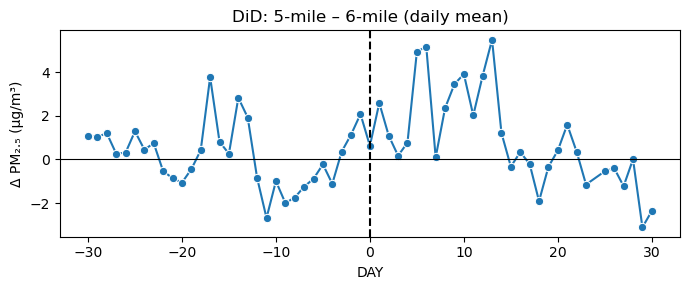


=== Mixed-effects ITS 模型 ===
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pm_value_list
No. Observations: 281684  Method:             ML           
No. Groups:       35      Scale:              19.5359      
Min. group size:  875     Log-Likelihood:     -818415.5388 
Max. group size:  20213   Converged:          Yes          
Mean group size:  8048.1                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         9.567    0.213 44.933 0.000  9.150  9.985
post              0.640    0.088  7.238 0.000  0.467  0.813
buffer_mi         0.079    0.004 22.307 0.000  0.072  0.086
post:buffer_mi   -0.044    0.005 -9.310 0.000 -0.053 -0.035
DAY               0.003    0.001  2.982 0.003  0.001  0.005
I(DAY ** 2)      -0.000    0.000 -9.326 0.000 -0.000 -0.000
OBJECTID Var      1.4

In [444]:
treat_buf = 5
ctrl_buf  = 6

daily = (df_exp.groupby(["buffer_mi","DAY"])["pm_value_list"]
               .mean().unstack("buffer_mi"))

did = daily[treat_buf] - daily[ctrl_buf]

# 前 / 后窗口
pre_idx  = did.index[(did.index >= -15) & (did.index <= -1)]
post_idx = did.index[(did.index >=  1) & (did.index <= 15)]

stat, p = wilcoxon(did.loc[pre_idx], did.loc[post_idx]) #Wilcoxon signed-rank 检验：因为同一个 DAY 序列内两窗口是配对的（一天对应一天），检验“事后差值”是否系统性高于“事前差值”。
print(f"\n=== DiD (buffer {treat_buf} vs {ctrl_buf}) ===")
print(f"Mean diff PRE = {did.loc[pre_idx].mean():.2f} µg/m³")
print(f"Mean diff POST = {did.loc[post_idx].mean():.2f} µg/m³")
print(f"Wilcoxon W = {stat:.1f},  p = {p:.3g}")

# （可选）画一下差值时间序列
plt.figure(figsize=(7,3))
sns.lineplot(x=did.index, y=did.values, marker="o")
plt.axvline(0, ls="--", c="k"); plt.axhline(0, c="k", lw=0.8)
plt.title(f"DiD: {treat_buf}-mile – {ctrl_buf}-mile (daily mean)")
plt.xlabel("DAY");  plt.ylabel("Δ PM₂.₅ (µg/m³)")
plt.tight_layout();  plt.show()

# 分层/混合效应模型（截断点 × 距离）分层/混合效应 Interrupted-Time-Series (ITS) 模型
# 我们的模型已经把 通常的日常变化（用 DAY 和 DAY² 捕捉）和不同火场本身的平均水平（随机截距）都扣掉了。

# 构造截断、距离交互项
df_exp["post"] = (df_exp.DAY > 0).astype(int)
# 若 buffer_mi 是连续变量可直接用；如果想 treat / ctrl dummy，也可自定义
model = mixedlm(
    "pm_value_list ~ post * buffer_mi + DAY + I(DAY**2)",
    groups   = "OBJECTID",       # 随火场截距
    data     = df_exp
    ).fit(reml=False)

print("\n=== Mixed-effects ITS 模型 ===")
print(model.summary())

# 拿出交互项系数 ⇒ 每增 1 mile, post 效应变化量
beta_post          = model.params["post"]
beta_post_bufSlope = model.params["post:buffer_mi"]
print(f"\n即时效应 (5-mile): {beta_post + 5*beta_post_bufSlope:.2f} ug")

- post:buffer_mi - 交互项： 事后效应是否随距离变化
  
- 事件对中心点即时增加 0.64 ug； - 在 0 mile 处，事件发生的当日及其后的“立即”时段，PM2.5 水平相对于“假如火灾没发生”所预测的浓度 额外增加 0.64 ug。
- 每远 1 mile 火灾效应递减 0.044 ug；
- 因此在 5 mile 处仅剩约 0.42 ug。